In [118]:
import sys 
import os
sys.path.append(os.path.abspath(os.path.join('../..')))

import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from data import PVDataGenerator, SystemLoader, PV_LFM_Dataset
from pv_plot import plot_train_test_split
from data.utils import *
from alfi.utilities.data import flatten_dataset
from models import ExactLFM


In [119]:
# data parameters
DAY_INIT = 200
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 3
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 4
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
NUM_OUTPUTS = 4
CIRCLE_COORDS = (53.5, -3)
RADIUS = 0.25


==> Loading data
==> Loaded data in: 0 m : 3 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



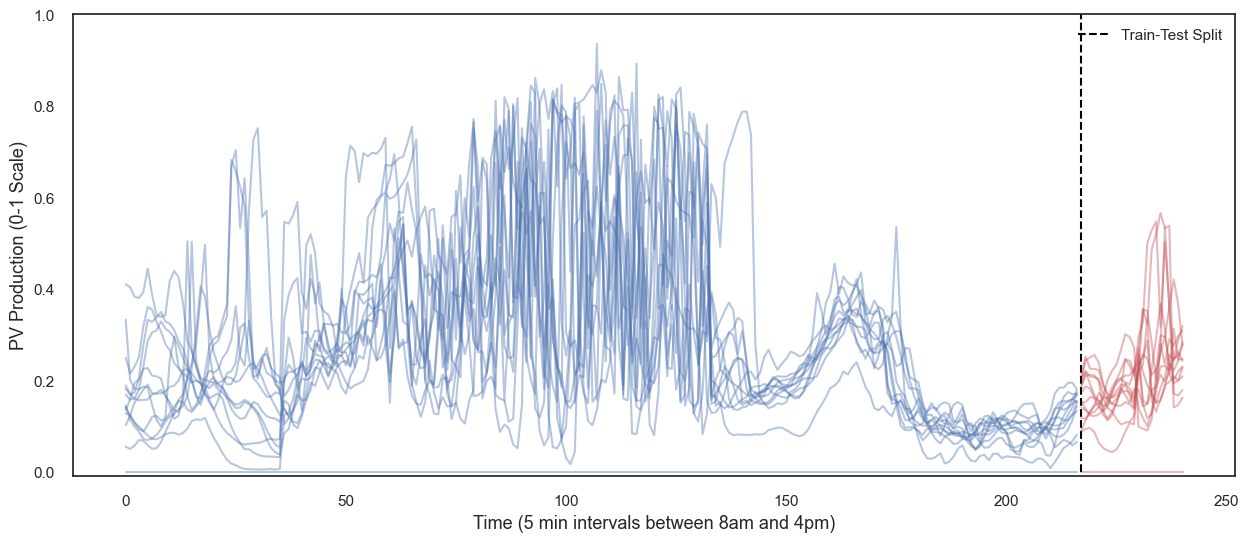

In [120]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')
# set text font to Arial
plt.rcParams['font.family'] = "Arial"

X, y = generator.get_time_series()
x_train, y_train, x_test, y_test = train_test_split(X, y, hour=12)
plot_train_test_split(y_train, y_test)


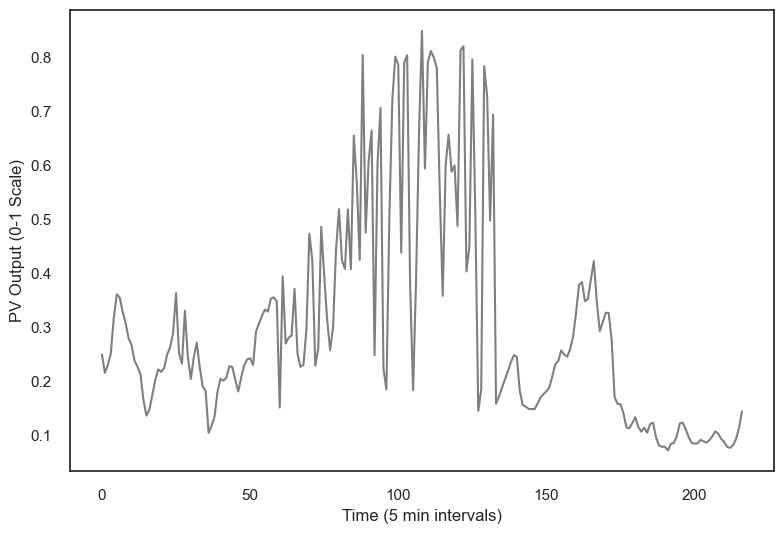

In [111]:
interval = 1

num_outputs = 1
x_obs = x_train[::interval] 
# add noise to observations
y_obs = y_train[::interval, :num_outputs] 

plt.plot(y_obs, color='black', alpha=0.5);
plt.xlabel('Time (5 min intervals)')
plt.ylabel('PV Output (0-1 Scale)')

plt.tight_layout()
plt.show();


# Exact Latent Force Model

In [112]:
m_observed = y_obs
f_observed = x_obs.unsqueeze(-1)

num_outputs = y_obs.shape[1]

t_obs = torch.linspace(0, 1, len(x_obs))
t_train = torch.linspace(0 + 1e-2 , 1 - 1e-2 , len(x_train)) 
t_test = torch.linspace(1, (len(x_test) + len(x_train))/len(x_train), len(x_test))
t = torch.concat([t_train, t_test], dim=0)
dataset = PV_LFM_Dataset(num_outputs, y_obs, x_obs, t_train[::interval], 0.6*torch.ones(num_outputs))
train_t, train_y = flatten_dataset(dataset)

train_t = train_t.view(-1, 1)
train_y = train_y.view(-1, 1)

In [113]:
t.shape, y[:,0].shape

(torch.Size([241]), torch.Size([288]))

In [114]:
model = ExactLFM(dataset, dataset.variance.reshape(-1)*2)                                                      
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model) 

In [115]:
from trainers import ExactTrainer

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]
trainer = ExactTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)

model.likelihood.train()
a = trainer.train(epochs=200, report_interval=50)


Epoch 001/200 - Loss: 0.79 λ: [0.08]
Epoch 051/200 - Loss: -0.66 λ: [0.08]
Epoch 101/200 - Loss: -0.67 λ: [0.08]
Epoch 151/200 - Loss: -0.67 λ: [0.08]


In [116]:
t_tr = torch.linspace(t_train.min(), t_train.max(), len(t_train)*2 )
t_te = torch.linspace(t_test.min(), t_test.max(), len(t_test))

mean_tr, lower_tr, upper_tr = model.pv_pred(t_tr)
mean_te, lower_te, upper_te = model.pv_pred(t_te)


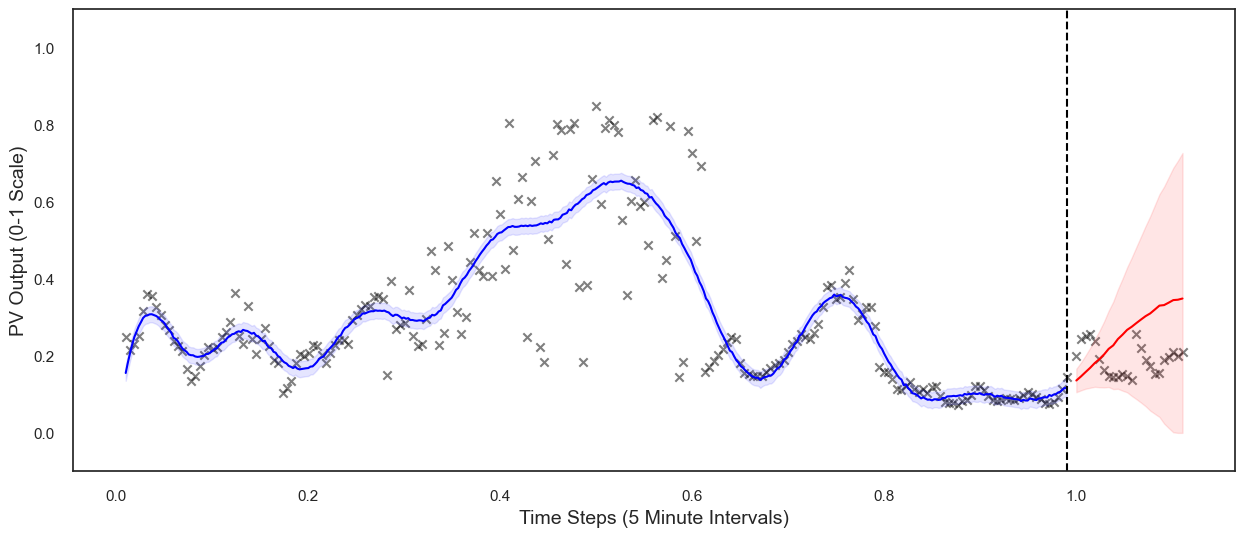

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax = ax.flatten() if num_outputs > 1 else [ax]

for i in range(num_outputs):
    ax[i].scatter(t_train, y_train[:, i], color='black', alpha=0.5, marker='x')
    ax[i].scatter(t_test, y_test[:, i], color='black', alpha=0.5, marker='x')
    mean, lower, upper = mean_tr, lower_tr, upper_tr
    ax[i].plot(t_tr, mean, color='blue')
    ax[i].fill_between(t_tr, lower, upper, alpha=0.1, color='blue')

    mean, lower, upper = mean_te, lower_te, upper_te
    ax[i].plot(t_te, mean, color='red')
    ax[i].fill_between(t_te, lower, upper, alpha=0.1, color='red')

    ax[i].axvline(t_train.max(), color='black', linestyle='--')

    ax[i].set_ylim(-0.1, 1.1)
    ax[i].set_xlabel('Time Steps (5 Minute Intervals)', fontsize=14)
    ax[i].set_ylabel('PV Output (0-1 Scale)', fontsize=14)

   




